In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## __Задание:__
## Проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 02.12.2022 по 08.12.2022 включительно. Для эксперимента были задействованы 2 и 1 группы. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. Необходимо проанализировать данные А/Б-теста.

In [2]:
dir_path = '~/data_files/'
df = pd.read_csv(dir_path + 'ab_test_data.zip', compression='zip')

df.head()

,exp_group,user_id,likes,views
0,1,109963,3,15
1,1,26117,32,141
2,1,138232,18,73
3,1,26295,33,122
4,1,18392,7,32


In [3]:
# Рассчитываем значение CTR.

df['ctr'] = round(df.likes / df.views, 3)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200
1,1,26117,32,141,0.227
2,1,138232,18,73,0.247
3,1,26295,33,122,0.270
4,1,18392,7,32,0.219


In [4]:
# Взглянем на CTR и количество пользователей в группах 1 и 2.

df.groupby('exp_group').agg({'user_id':'count','ctr':'mean'})

,user_id,ctr
exp_group,,
1,10079,0.215604
2,9952,0.214407


In [5]:
# Сделаем графики в seaborn покрупнее.

sns.set(rc={'figure.figsize':(11.7,8.27)})

[Text(0.5, 0, 'CTR'), Text(0, 0.5, '')]

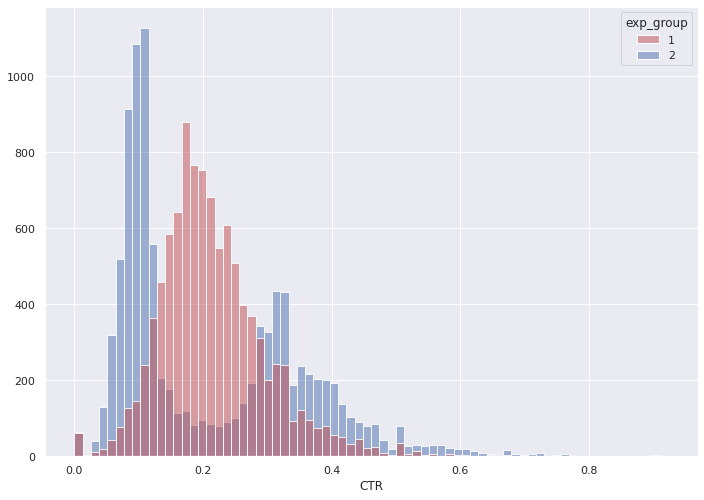

In [6]:
# Нарисуем распределения CTR в группах 1 и 2, чтобы ознакомиться с их формой и визуально оценить,
# насколько метрики в этих группах похожи.

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
groups.set(xlabel='CTR', ylabel='')

## Как видно на получившемся графике распределения CTR в группах 1 и 2 заметно отличаются. В контрольной группе распределение близко к нормальному, однако в тестовой группе оно совсем ненормально, поскольку имеет 2 пика, скошено влево и имеет выбросы справа.

In [7]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [8]:
# Проведём сравнение обеих групп t-тестом.

_, pval_t = stats.ttest_ind(group1.ctr,
                group2.ctr,
                equal_var=False)

print('Полученное в результате проведения t-теста значение p-value =', pval_t)

Полученное в результате проведения t-теста значение p-value = 0.4738007466000528


## Поскольку значение p-value оказалось значительно больше 0.05, то по результатам проведения t-теста мы не сможем отклонить нулевую гипотезу о равенстве расределений тестовой и контрольной групп. Однако визуально на графике выше мы уже убедились в существенных отличиях распределения CTR в этих двух группах. Поэтому с t-тестом мы совершаем ошибку 2 рода. Это связано с равенством средних значений CTR тестовой и контрольной групп (они выводились выше, при подключении к БД), что заставляет t-тест ошибочно считать эти распределения похожими.

In [9]:
# Проведём сравнение обеих групп тестом Манна-Уитни.

_, pval_u = stats.mannwhitneyu(group1.ctr,
                group2.ctr,
                alternative='two-sided')

print('Полученное в результате проведения теста Манна-Уитни значение p-value =', pval_u)

Полученное в результате проведения теста Манна-Уитни значение p-value = 6.145564141609496e-56


## Поскольку значение p-value оказалось практически равно 0 (и существенно меньше порога в 0.05), то по результатам проведения теста Манна-Уитни мы сможем верно отклонить нулевую гипотезу о равенстве расределений тестовой и контрольной групп. Причина, по которой тест Манна-Уитни не совершаем ошибку 2 рода по сравнению с t-тестом, заключается в том, что средние значения CTR тестовой и контрольной групп не влияют на расчёт p-value в данном тесте. Тест Манна-Уитни сравнивает ранги (определяет, достаточно ли мала зона перекрещивающихся значений между двумя рядами) и не слишком привязан к типу распределения рассматриваемых метрик.

In [10]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [11]:
# Посчитаем глобальный CTR

global_ctr_1 = group1.likes.sum() / group1.views.sum()
global_ctr_2 = group2.likes.sum() / group2.views.sum()

[Text(0.5, 0, 'сглаженный CTR'), Text(0, 0.5, '')]

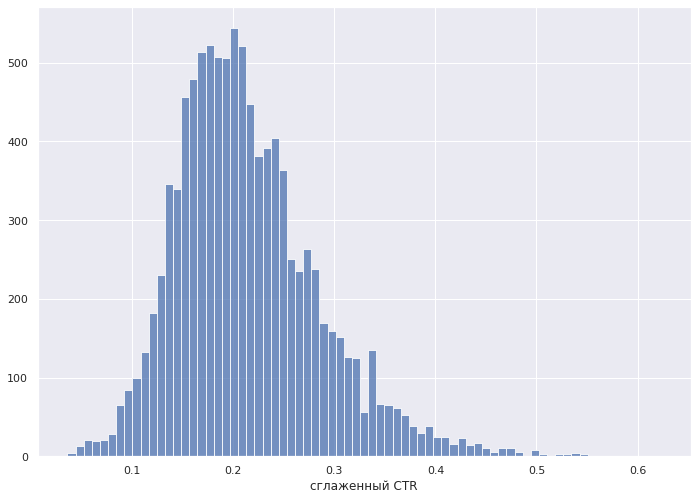

In [12]:
# Посчитаем сглаженный CTR для контрольной группы с гиперпараметром α=5 и отобразим распределение полученной величины.

group1['smothed_ctr'] = group1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

plot1 = sns.histplot(group1.smothed_ctr, 
             kde = False)
plot1.set(xlabel='сглаженный CTR', ylabel='')

[Text(0.5, 0, 'сглаженный CTR'), Text(0, 0.5, '')]

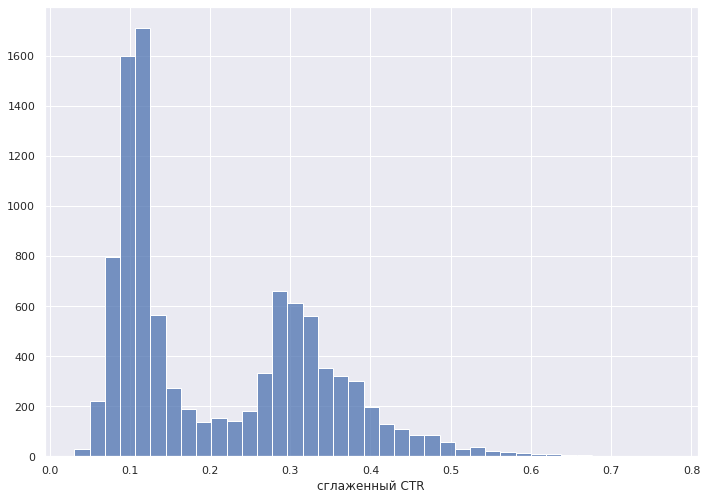

In [13]:
# Посчитаем сглаженный CTR для тестовой группы с гиперпараметром α=5 и отобразим распределение полученной величины.

group2['smothed_ctr'] = group2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)


plot2 = sns.histplot(group2.smothed_ctr, 
             kde = False)
plot2.set(xlabel='сглаженный CTR', ylabel='')

## Теперь проведём сравнение сглаженных CTR обеих групп t-тестом.

In [14]:
_, pval_t = stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

print('Полученное в результате проведения t-теста значение p-value =', pval_t)

Полученное в результате проведения t-теста значение p-value = 0.0223769815558559


In [15]:
print('Среднее значение сглаженного CTR контрольной группы =', group1.smothed_ctr.mean())
print('Среднее значение сглаженного CTR тестовой группы =', group2.smothed_ctr.mean())

Среднее значение сглаженного CTR контрольной группы = 0.21402549608884142
Среднее значение сглаженного CTR тестовой группы = 0.21073955503259234


## На этот раз значение p-value оказалось меньше порога в 0.05, поэтому по результатам проведения t-теста на расределениях сглаженных CTR тестовой и контрольной групп мы сможем верно отклонить нулевую гипотезу о равенстве этих групп. Причина, по которой на сглаженных значениях CTR t-тест сработал корректно, заключается в том, что сглаживание позволило избавиться от шума (пользователи с небольшим количеством просмотров). Однако проблема сглаженного CTR состоит в том, что нет гарантии, что его направленность совпадает с направленностью общего количества кликов.

In [16]:
def poisson_bootstrap(likes1, views1, likes2, views2, iterations=1000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (iterations, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (iterations, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1) / (poisson_bootstraps1*views1).sum(axis=1)    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1) / (poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

## Проведем пуассоновский бутстрап для общегруппового CTR в обеих группах (2000 подвыборок для каждой группы) и отобразим полученные распределения величины для каждой из групп.

In [17]:
likes1 = group1.likes.to_numpy()
views1 = group1.views.to_numpy()
likes2 = group2.likes.to_numpy()
views2 = group2.views.to_numpy()

ctr1, ctr2 = poisson_bootstrap(likes1, views1, likes2, views2, iterations=2000)

Text(0.5, 0, 'CTR')

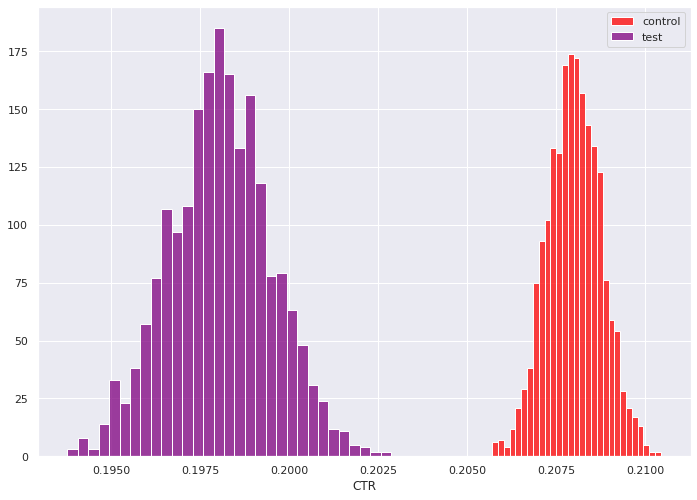

In [19]:
sns.histplot(ctr1, color='red')
sns.histplot(ctr2, color='purple')
plt.legend(labels=['control', 'test'])
plt.ylabel('')
plt.xlabel('CTR')

## По результатам построенного графика распределений, полученных пуассоновским бутстрапом CTR для обеих групп, можно видеть, что распределения не пересекаются, поэтому нулевая гипотеза может быть отвергнута. Также мы наблюдаем снижение значения CTR в тестовой группе, по сравнению с контрольной группой. Это означает, что обновление скорее всего выкатывать не стоит, чтобы не ухудшить показатели метрики CTR. Пока отложим принятие решения и прогоним наши данные через t-тест и тест Манна-Уитни для того, чтобы убедиться в правильности нашей визуальной интерпритации, а также проведём бакетное преобразование и прогоним t-тест и тест Манна-Уитни для преобразованных данных.

In [20]:
# Проведём сравнение полученных пуассоновским бутстрапом CTR для обеих групп t-тестом.

_, pval_t = stats.ttest_ind(ctr1, ctr2, equal_var=False)

print('Полученное в результате проведения t-теста значение p-value =', pval_t)

Полученное в результате проведения t-теста значение p-value = 0.0


In [21]:
# Проведём сравнение полученных пуассоновским бутстрапом CTR для обеих групп тестом Манна-Уитни.

_, pval_u = stats.mannwhitneyu(ctr1, ctr2, alternative='two-sided')

print('Полученное в результате проведения теста Манна-Уитни значение p-value =', pval_u)

Полученное в результате проведения теста Манна-Уитни значение p-value = 0.0


## После проведения t-теста и теста Манна-Уитни на полученных пуассоновским бутстрапом значениях CTR для пользовательских групп 1 и 2 можно уверенно сказать, что предположение о неравенстве распределений подтвердилось, также как подтвердилось и снижение значения CTR в тестовой группе, по сравнению с контрольной группой.

In [25]:
# Разделим на бакеты тестовую и контрольную группы, после чего проведём последние два теста (t-тест и тест Манна-Уитни)
# на значениях CTR, посчитанных для групп (бакетов) пользователей.

n_bins = 50

df_with_buckets = df.copy()
df_with_buckets['bucket'] = df_with_buckets.user_id.apply(lambda x: (hash(x) % n_bins) + 1)
df_with_buckets = df_with_buckets.groupby(['exp_group', 'bucket'], as_index=False).agg({'likes':'sum','views':'sum'})
df_with_buckets['bucket_ctr'] = round(df_with_buckets.likes / df_with_buckets.views, 3)

df_with_buckets.head()

,exp_group,bucket,likes,views,bucket_ctr
0,1,1,2729,13821,0.197
1,1,2,2675,12466,0.215
2,1,3,3275,15138,0.216
3,1,4,2844,13897,0.205
4,1,5,2453,11661,0.210


In [26]:
df_with_buckets.groupby('exp_group').agg({'bucket':'nunique','bucket_ctr':'mean'}).rename(columns={'bucket_ctr': 'avg_bucket_ctr'})

,bucket,avg_bucket_ctr
exp_group,,
1,50,0.20810
2,50,0.19808


Text(0.5, 0, 'CTR')

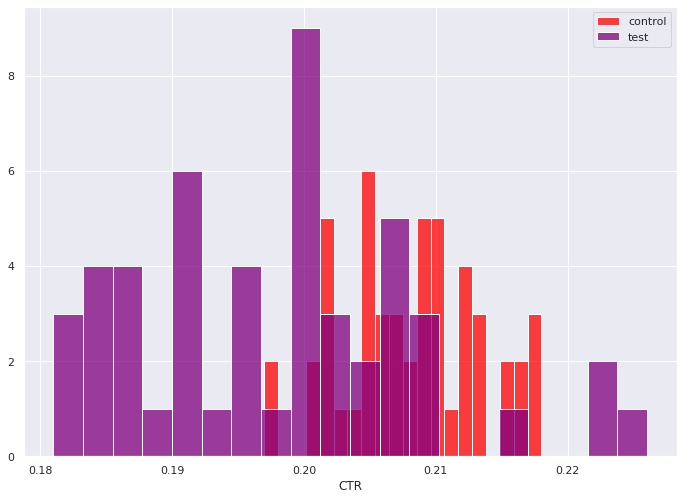

In [29]:
# Изобразим распределения CTR пользовательских бакетов для обеих групп.

sns.histplot(df_with_buckets[df_with_buckets.exp_group == 1].bucket_ctr, color='red', bins=20)
sns.histplot(df_with_buckets[df_with_buckets.exp_group == 2].bucket_ctr, color='purple', bins=20)
plt.legend(labels=['control', 'test'])
plt.ylabel('')
plt.xlabel('CTR')

In [30]:
# Проведём сравнение обеих групп бакетов t-тестом.

_, pval_t = stats.ttest_ind(df_with_buckets[df_with_buckets.exp_group == 1].bucket_ctr,
                df_with_buckets[df_with_buckets.exp_group == 2].bucket_ctr,
                equal_var=False)

print('Полученное в результате проведения t-теста значение p-value =', pval_t)

Полученное в результате проведения t-теста значение p-value = 1.1226454834121217e-07


In [31]:
# Проведём сравнение обеих групп бакетов тестом Манна-Уитни.

_, pval_u = stats.mannwhitneyu(df_with_buckets[df_with_buckets.exp_group == 1].bucket_ctr,
                df_with_buckets[df_with_buckets.exp_group == 2].bucket_ctr,
                alternative='two-sided')

print('Полученное в результате проведения теста Манна-Уитни значение p-value =', pval_u)

Полученное в результате проведения теста Манна-Уитни значение p-value = 5.830752033123653e-08


## На основании проведенного А/Б-теста можно сделать вывод о том, что тестовая и контрольная группы значимо различаются, но при этом у тестовой группы средний показатель CTR ниже, чем у контрольной группы. У определенной доли пользователей среди тестовой группы увеличился показатель CTR (сдвинулся вправо относительно среднего значения распределения контрольной группы), однако у большей доли пользователей среди тестовой группы произошло ухудшение данного показателя (сдвинулся влево относительно среднего значения распределения контрольной группы). Это может означать, что на часть пользователей новый алгоритм подействовал положительно, как задумано, однако у большинства пользователей среди тестовой группы из-за нового алгоритма CTR снизился. Именно поэтому распределение CTR тестовой группы имеет два пика. Поэтому итоговым советом будет отказаться раскатывать новый алгоритм на всех новых пользователей, поскольку с большой вероятностью он не понравиться большей части нашей аудитории.